In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm

from matplotlib import pyplot as plt


/Users/bradeneberhard/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/bradeneberhard/miniforge3/envs/mlp/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: c62c9ec403b441913c987cacdfaf4d7a0bf0e7f2- is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
DATA = pd.read_csv('~/Downloads/all_games_test.csv')

/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_74011/426526817.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  DATA = pd.read_csv('~/Downloads/all_games_test.csv')


In [4]:
def get_offensive_team(GAME):
    home_team_offense = []
    prev_home_score = -1
    for idx, row in GAME.iterrows():
        if prev_home_score == -1:
            home_team_offense.append(0)
        elif row.home_team_score > prev_home_score:
            home_team_offense.append(-1)
        else:
            home_team_offense.append(1)
        prev_home_score = row.home_team_score
    return home_team_offense

def get_crunch_time(row):
    if row.total_game_time > 100:
        return 0
    if row.score_diff < -1:
        return -1
    elif row.score_diff > 1:
        return 1
    return 0

In [5]:
all_games = []
for gameID in DATA.gameID.unique():
    GAME = DATA[(DATA.gameID == gameID)]
    GAME['total_score'] = GAME['home_team_score'] + GAME['away_team_score']
    home_team_win = GAME[['away_team_score', 'home_team_score']].max().values.argmax()
    features = ['point_start_time', 'game_quarter', 'home_team_score', 'away_team_score', 'home_teamID', 'away_teamID']
    GAME = GAME.groupby('total_score').first()[features]
    GAME['score_diff'] = GAME['home_team_score'] - GAME['away_team_score']
    GAME['home_team_win'] = home_team_win
    GAME['home_team_offense'] = get_offensive_team(GAME)
    GAME['total_game_time'] = 12*4*60 - GAME['game_quarter']*12*60 + GAME['point_start_time']
    GAME['crunch_time'] = GAME.apply(get_crunch_time, axis=1)

    all_games.append(GAME.dropna())

/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_74011/1371678219.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GAME['total_score'] = GAME['home_team_score'] + GAME['away_team_score']
/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_74011/1371678219.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GAME['total_score'] = GAME['home_team_score'] + GAME['away_team_score']
/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_74011/1371678219.py:4: SettingWithCopyWarning: 
A val

In [6]:
ALL_GAMES = pd.concat(all_games)
train_data, test_data = train_test_split(ALL_GAMES.drop(['home_teamID', 'away_teamID'], axis=1))
X_train, y_train = train_data.drop('home_team_win', axis=1), train_data.home_team_win
X_test, y_test = test_data.drop('home_team_win', axis=1), test_data.home_team_win
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=train_data.drop('home_team_win', axis=1).columns)
X_test_scaled =  pd.DataFrame(scaler.fit_transform(X_test), columns=train_data.drop('home_team_win', axis=1).columns)

In [7]:
glm = LogisticRegression(max_iter=1000)
glm.fit(X_train, y_train)
y_pred = glm.predict_proba(X_test)[:,1]
roc_auc_score(y_test.values, y_pred)

0.8889886256854224

In [8]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:          home_team_win   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     1210.
Date:                Sat, 24 Jun 2023   Prob (F-statistic):               0.00
Time:                        17:40:47   Log-Likelihood:                -5646.2
No. Observations:               11710   AIC:                         1.131e+04
Df Residuals:                   11703   BIC:                         1.136e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0280      0.00

In [9]:
log_odds = glm.coef_[0]
pd.DataFrame(log_odds, X_train.columns, columns=['coef']).sort_values(by='coef', ascending=False)

,coef
score_diff,0.473773
home_team_score,0.243903
home_team_offense,0.208576
crunch_time,0.028716
total_game_time,0.000057
point_start_time,0.000016
game_quarter,-0.112698
away_team_score,-0.229870


In [10]:
ALL_GAMES.corr()

,point_start_time,game_quarter,home_team_score,away_team_score,score_diff,home_team_win,home_team_offense,total_game_time,crunch_time
point_start_time,1.000000,0.022353,0.245804,0.249875,0.008902,0.007414,0.038875,0.237674,-0.023046
game_quarter,0.022353,1.000000,0.873025,0.871438,0.055402,-0.007284,-0.013388,-0.965789,0.016636
home_team_score,0.245804,0.873025,1.000000,0.782185,0.383616,0.200952,-0.073918,-0.784460,0.082001
away_team_score,0.249875,0.871438,0.782185,1.000000,-0.275320,-0.205885,0.078419,-0.781863,-0.057853
score_diff,0.008902,0.055402,0.383616,-0.275320,1.000000,0.615233,-0.230288,-0.051519,0.212279
home_team_win,0.007414,-0.007284,0.200952,-0.205885,0.615233,1.000000,-0.127187,0.009000,0.153663
home_team_offense,0.038875,-0.013388,-0.073918,0.078419,-0.230288,-0.127187,1.000000,0.023091,-0.040729
total_game_time,0.237674,-0.965789,-0.784460,-0.781863,-0.051519,0.009000,0.023091,1.000000,-0.022141
crunch_time,-0.023046,0.016636,0.082001,-0.057853,0.212279,0.153663,-0.040729,-0.022141,1.000000


In [12]:
(DATA.gameID.unique() == '2021-09-10-RAL-CHI').argmax()

126

In [84]:
[x for x in DATA.gameID.unique() if 'SLC' in x]

['2023-05-19-LA-SLC',
 '2023-04-28-SEA-SLC',
 '2023-05-05-SLC-POR',
 '2023-06-03-OAK-SLC',
 '2023-06-16-COL-SLC',
 '2023-06-09-SLC-COL',
 '2023-05-13-SLC-OAK',
 '2023-05-06-SLC-SEA',
 '2022-07-09-SLC-POR',
 '2022-06-03-OAK-SLC',
 '2022-07-08-SLC-SEA',
 '2022-08-13-SD-SLC',
 '2022-08-20-SLC-COL',
 '2022-05-28-SLC-COL',
 '2022-05-13-SEA-SLC',
 '2022-04-29-SLC-SD',
 '2022-04-30-SLC-LA',
 '2022-06-10-COL-SLC',
 '2022-06-24-SD-SLC',
 '2022-07-16-SLC-OAK',
 '2022-07-29-POR-SLC',
 '2022-07-22-LA-SLC']

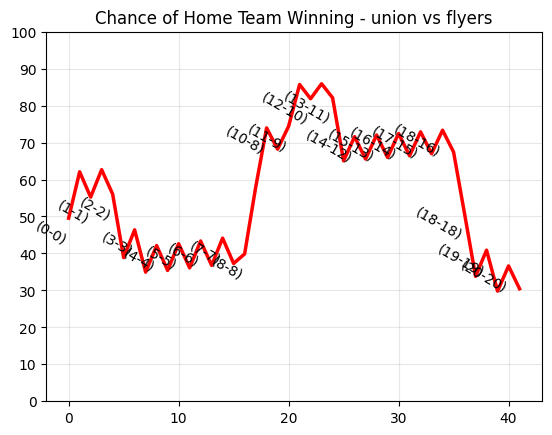

In [13]:
game_num=126
game = all_games[game_num].drop(['home_teamID', 'away_teamID', 'home_team_win'], axis=1)
home_team = all_games[game_num].home_teamID[0]
away_team = all_games[game_num].away_teamID[0]
# game = all_games[13].drop('home_team_win', axis=1)
# game_scaled = pd.DataFrame(scaler.transform(game), columns=game.columns)
predictions = glm.predict_proba(game)[:,1]*100
plt.plot(predictions, 'r', linewidth=2.5)
for idx, row in game[::2].iterrows():
    plt.annotate(f'({int(row.home_team_score)}-{int(row.away_team_score)})', (idx, predictions[idx] - 7), ha='right', rotation=-30)

plt.ylim([0,100])
plt.yticks(np.arange(0, 101, step=10))
plt.grid(alpha=0.3)
plt.title(f'Chance of Home Team Winning - {home_team} vs {away_team}')
plt.show()

In [92]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
sampler = RandomOverSampler()
X_sampled, y_sampled = sampler.fit_resample(X_train, y_train)


max_depth=4
n_estimators=500
lr=0.001
xgb_model = xgb.XGBClassifier(seed=1, max_depth=max_depth, n_estimators=n_estimators, use_label_encoder=False, eval_metric='logloss', learning_rate=lr)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict_proba(X_test)[:,1]
roc_auc_score(y_test.values, y_pred)



/Users/bradeneberhard/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.8939803009452956